In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from DataGenerator import *
from Competition import *
from config import * 
from generic_analyzer import *
from utils.common_helpers import *

In [2]:
BN_EO = initialize_BN()
dataset = BN_EO.simulate(n_samples=50000, seed=SEED)

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
C1_label = 'COLLEGE'
C1_features = ['SES', 'SEX', 'SAT', 'SCHOOL']
C1 = Competition(dataset, C1_features, C1_label, ['SEX', 'SES'], [0,0])

In [4]:
C2_label = 'INTERN'
C2_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA']
C2 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [5]:
C3_label = 'JOB'
C3_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA','INTERN']
C3 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [6]:
X_train, y_train, X_test, y_test, X_val, y_val = C1.create_train_test_val_split(SEED=44)
X_train.shape, X_test.shape, X_val.shape

((30000, 4), (10000, 4), (10000, 4))

In [7]:
# Using the same seed so that all contests share the same split
__ = C2.create_train_test_val_split(SEED=44)
__ = C3.create_train_test_val_split(SEED=44)

In [8]:
best_model = LogisticRegression(C=1, max_iter=200, random_state=SEED, solver='newton-cg')

In [9]:
C1.fit_base_model(best_model)

0.7459

In [10]:
y_preds1 = C1.predict(C1.X_test)
y_probs1 = C1.predict_proba(C1.X_test)

In [11]:
Analyzer = GenericAnalyzer(C1.X_test, C1.y_test, ['SEX','SES'], [0, 0])

for i in Analyzer.test_groups.keys():
    print(i, Analyzer.test_groups[i].shape[0]/Analyzer.X_test.shape[0])

SEX_SES_priv 0.1191
SEX_SES_dis 0.8809
SEX_priv 0.6057
SEX_dis 0.3943
SES_priv 0.2004
SES_dis 0.7996


In [12]:
c1_res = Analyzer.compute_metrics(y_preds1, 'Base_Model')
print(pd.DataFrame(c1_res).to_markdown())

|                |   overall |   SEX_SES_priv |   SEX_SES_dis |   SEX_priv |   SEX_dis |   SES_priv |   SES_dis |
|:---------------|----------:|---------------:|--------------:|-----------:|----------:|-----------:|----------:|
| TPR            |  0.73859  |       1        |      0.654672 |   0.808608 |  0.546512 |  0.955776  |  0.615356 |
| TNR            |  0.751161 |       0        |      0.774331 |   0.616722 |  0.893451 |  0.216769  |  0.800225 |
| PPV            |  0.681137 |       0.853904 |      0.619659 |   0.683949 |  0.669956 |  0.790825  |  0.606945 |
| FNR            |  0.26141  |       0        |      0.345328 |   0.191392 |  0.453488 |  0.0442244 |  0.384644 |
| FPR            |  0.248839 |       1        |      0.225669 |   0.383278 |  0.106549 |  0.783231  |  0.199775 |
| Accuracy       |  0.7459   |       0.853904 |      0.731298 |   0.713885 |  0.79508  |  0.775449  |  0.738494 |
| F1             |  0.708701 |       0.921196 |      0.636685 |   0.741073 |  0.60197  |

In [13]:
def find_q_val(y, alpha):
    n = len(y)
    alpha_corrected = ((n+1)*(1-alpha))/n

    pos = int(round(alpha_corrected*n))
    return np.sort(y)[pos]

In [30]:
Analyzer.y_test

49457    1
20706    1
46059    0
38076    1
8394     1
        ..
34398    0
41323    1
17138    1
14034    1
31387    1
Name: COLLEGE, Length: 10000, dtype: int64

In [33]:
Analyzer.X_test

,SES,SEX,SAT,SCHOOL
49457,1,1,2,2
20706,1,0,2,0
46059,2,1,1,2
38076,2,1,2,2
8394,2,1,2,2
...,...,...,...,...
34398,2,0,0,0
41323,1,0,1,0
17138,1,1,2,2
14034,1,0,1,0


In [ ]:
[C1.predict_proba(Analyzer.X_test)[]]

In [14]:
alpha = 0.7
q_vals = {}
y_back_fair = {}

y_probs = C1.predict_proba(Analyzer.X_test)[:,0]
print("Overall ", find_q_val(y_probs, alpha))

for g in Analyzer.test_groups.keys():
    y_probs = C1.predict_proba(Analyzer.test_groups[g])[:,0]
    q_vals[g] = find_q_val(y_probs, alpha)
    y_back_fair[g] = np.array([int(y__ > q_vals[g]) for y__ in y_probs])
    
    print(g, q_vals[g])
    

Overall  0.17471698840829064
SEX_SES_priv 0.7825703357813271
SEX_SES_dis 0.16967369727880555
SEX_priv 0.2977231576566781
SEX_dis 0.15119575678497088
SES_priv 0.6061864830842922
SES_dis 0.16967369727880555


In [15]:
interventions = {
    "SEX": ['SEX_priv', 'SEX_dis'],
    "SES": ['SES_priv', 'SES_dis'],
    "SEX_SES" : ['SEX_SES_priv', 'SEX_SES_dis']
}

In [16]:
y_preds_back = {}

for level in interventions:
    y_preds_back[level] = pd.DataFrame({}, columns = Analyzer.X_test.columns)

    for g in interventions[level]:
        temp = Analyzer.test_groups[g].copy(deep=True)
        temp["y_fair"] = y_back_fair[g]
        y_preds_back[level] = y_preds_back[level].append(temp)

In [17]:
y_preds_back['SEX'].shape, y_preds_back['SES'].shape, y_preds_back['SEX_SES'].shape, Analyzer.X_test.shape

((10000, 5), (10000, 5), (10000, 5), (10000, 4))

In [18]:
y_preds_back['Control'] = {'y_fair' : pd.Series(y_preds1)}

In [19]:
res_df = {}
for i in y_preds_back.keys():
    res_df[i] = Analyzer.compute_metrics(y_preds_back[i]['y_fair'].values, i)
    print(i)
    print(pd.DataFrame(res_df[i]).to_markdown())
    print("   \n")

SEX
|                |   overall |   SEX_SES_priv |   SEX_SES_dis |   SEX_priv |   SEX_dis |   SES_priv |   SES_dis |
|:---------------|----------:|---------------:|--------------:|-----------:|----------:|-----------:|----------:|
| TPR            |  0.32282  |       0.317601 |      0.324495 |   0.321487 |  0.326476 |   0.319472 |  0.324719 |
| TNR            |  0.684953 |       0.655172 |      0.685871 |   0.682274 |  0.687788 |   0.662577 |  0.687007 |
| PPV            |  0.424442 |       0.843342 |      0.367143 |   0.509298 |  0.292702 |   0.745763 |  0.342147 |
| FNR            |  0.67718  |       0.682399 |      0.675505 |   0.678513 |  0.673524 |   0.680528 |  0.675281 |
| FPR            |  0.315047 |       0.344828 |      0.314129 |   0.317726 |  0.312212 |   0.337423 |  0.312993 |
| Accuracy       |  0.5334   |       0.366919 |      0.555909 |   0.499587 |  0.585341 |   0.403194 |  0.566033 |
| F1             |  0.366721 |       0.461429 |      0.344504 |   0.394164 |  0.3086

In [20]:
res_df.keys()

dict_keys(['SEX', 'SES', 'SEX_SES', 'Control'])

In [21]:
res_df['SEX']['overall'].keys()

dict_keys(['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate'])

In [22]:
def get_res_as_list(res_df, intervention, test_group, metric_name):
    return res_df[intervention][test_group][metric_name]

In [23]:
interventions

{'SEX': ['SEX_priv', 'SEX_dis'],
 'SES': ['SES_priv', 'SES_dis'],
 'SEX_SES': ['SEX_SES_priv', 'SEX_SES_dis']}

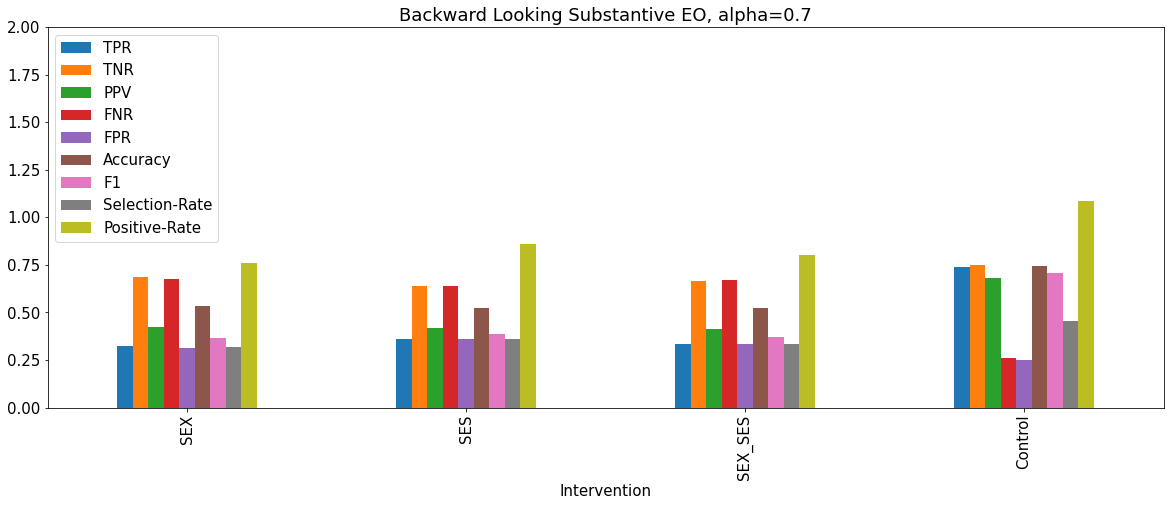

In [24]:
temp = pd.DataFrame({})
for m in ['TPR', 'TNR', 'PPV', 'FNR', 'FPR', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate']: 
    res_m = [get_res_as_list(res_df, i, 'overall', m) for i in res_df.keys()]
    #print(res_m)
    temp[m] = np.array(res_m).astype(float)
    temp["Intervention"] = list(res_df.keys())
    
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 15
temp.plot.bar(x="Intervention", title="Backward Looking Substantive EO, alpha="+str(alpha), ylim=(0,2))
    
plt.show()   

In [25]:
Analyzer.y_test.value_counts()

1    5815
0    4185
Name: COLLEGE, dtype: int64

In [29]:
res_df['SEX']['overall']

{'TPR': 0.3228195937873357,
 'TNR': 0.6849527085124677,
 'PPV': 0.42444234998429153,
 'FNR': 0.6771804062126643,
 'FPR': 0.31504729148753224,
 'Accuracy': 0.5334,
 'F1': 0.36672095548317046,
 'Selection-Rate': 0.3183,
 'Positive-Rate': 0.760573476702509}